In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats import uniform, randint

In [2]:
df = pd.read_csv("../data/process/clean_ai_salary_2025_merged_final.csv")
df.head()

,job_id,job_title,salary_usd,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,ML Engineer,61895,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


In [3]:
X = df.drop('salary_usd', axis=1)
y = df['salary_usd']

# Feature Selection  
### Dropped Columns:
* job_id - index number not that useful
* salary_currency - salary already in usd
* posting_date - assuming dates not helpful for salary predictions
* application_deadline - assuming dates not helpful for salary predictions
* company_name - too many company names and probably not very helpful for salary predictions

In [4]:
print(X.dtypes)

job_id                     object
job_title                  object
experience_level           object
employment_type            object
company_location           object
company_size               object
employee_residence         object
remote_ratio                int64
required_skills            object
education_required         object
years_experience            int64
industry                   object
posting_date               object
application_deadline       object
job_description_length      int64
benefits_score            float64
company_name               object
dtype: object


In [5]:
columns_to_drop = ['job_id', 'posting_date', 'application_deadline', 'company_name']
X = X.drop(columns=columns_to_drop)
print(X.dtypes)

job_title                  object
experience_level           object
employment_type            object
company_location           object
company_size               object
employee_residence         object
remote_ratio                int64
required_skills            object
education_required         object
years_experience            int64
industry                   object
job_description_length      int64
benefits_score            float64
dtype: object


In [6]:
categorical_cols = [
    "job_title",
    "experience_level",
    "employment_type",
    "company_location",
    "company_size",
    "employee_residence",
    "education_required",
    "industry"
]

numeric_cols = [
    "remote_ratio",
    "years_experience",
    "job_description_length",
    "benefits_score"
]

text_col = "required_skills"

# Data Preprocessing
* Use One Hot Encoding on Categorical Features
* Standardize Numerical Features
* Multi-hot Encoding for Skills

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
        ("skills", CountVectorizer(tokenizer=lambda s: s.split(", "), token_pattern=None, binary=True), text_col)
    ],
    remainder="drop"
)


In [9]:
gbr = GradientBoostingRegressor(random_state=42)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", gbr)
])

# Hyperparameter Turning
### Randomized Search CV
* Randomly samples a combination of hyperparameters from a certain distribution or range of values
* Computationally inexpensive because it explores a wide range of values without trying every combination
* Identifies approximate regions where good hyperparameters lie

In [10]:
param_dist = {
    "model__n_estimators": randint(100, 700),
    "model__learning_rate": uniform(0.01, 0.3),
    "model__max_depth": randint(2, 6),
    "model__subsample": uniform(0.5, 0.5),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10)
}

In [11]:
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__learning_rate': <scipy.stats....t 0x139a84aa0>, 'model__max_depth': <scipy.stats....t 0x139bfb770>, 'model__min_samples_leaf': <scipy.stats....t 0x139bfba70>, 'model__min_samples_split': <scipy.stats....t 0x139bfb980>, ...}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [12]:
print(f'Best params from random search: {random_search.best_params_}')

Best params from random search: {'model__learning_rate': np.float64(0.051256283243797975), 'model__max_depth': 5, 'model__min_samples_leaf': 9, 'model__min_samples_split': 19, 'model__n_estimators': 250, 'model__subsample': np.float64(0.770723986913783)}


In [13]:
random_search_model = random_search.best_estimator_

y_pred = random_search_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Randomized Search MAE:", mae)
print("Randomized Search RMSE:", rmse)
print("Randomized Search R²:", r2)

Randomized Search MAE: 12869.584488203398
Randomized Search RMSE: 17082.722630192347
Randomized Search R²: 0.8859163553882128


### Grid Search CV
* Explore the region found from the best hyperparameters in randomized search, make small changes to those hyperparameters
* Computationally expensive as grid search brute forces every combination from the given grid

In [14]:
best = random_search.best_params_

param_grid = {
    "model__n_estimators": [best["model__n_estimators"] - 50,
                            best["model__n_estimators"],
                            best["model__n_estimators"] + 50],

    "model__learning_rate": [best["model__learning_rate"] * 0.5,
                             best["model__learning_rate"],
                             best["model__learning_rate"] * 1.5],

    "model__max_depth": [best["model__max_depth"] - 1,
                         best["model__max_depth"],
                         best["model__max_depth"] + 1],

    "model__subsample": [max(0.5, best["model__subsample"] - 0.1),
                         best["model__subsample"],
                         min(1.0, best["model__subsample"] + 0.1)]
}

In [15]:
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__learning_rate': [np.float64(0....8141621898987), np.float64(0....6283243797975), ...], 'model__max_depth': [4, 5, ...], 'model__n_estimators': [200, 250, ...], 'model__subsample': [np.float64(0.670723986913783), np.float64(0.770723986913783), ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...), ...]"


In [16]:
print(f'Best params from grid search: {grid_search.best_params_}')

Best params from grid search: {'model__learning_rate': np.float64(0.051256283243797975), 'model__max_depth': 4, 'model__n_estimators': 300, 'model__subsample': np.float64(0.8707239869137829)}


# Final Evaluations

In [17]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final MAE:", mae)
print("Final RMSE:", rmse)
print("Final R²:", r2)

Final MAE: 12869.818380466708
Final RMSE: 17068.892619659233
Final R²: 0.8861010026910707


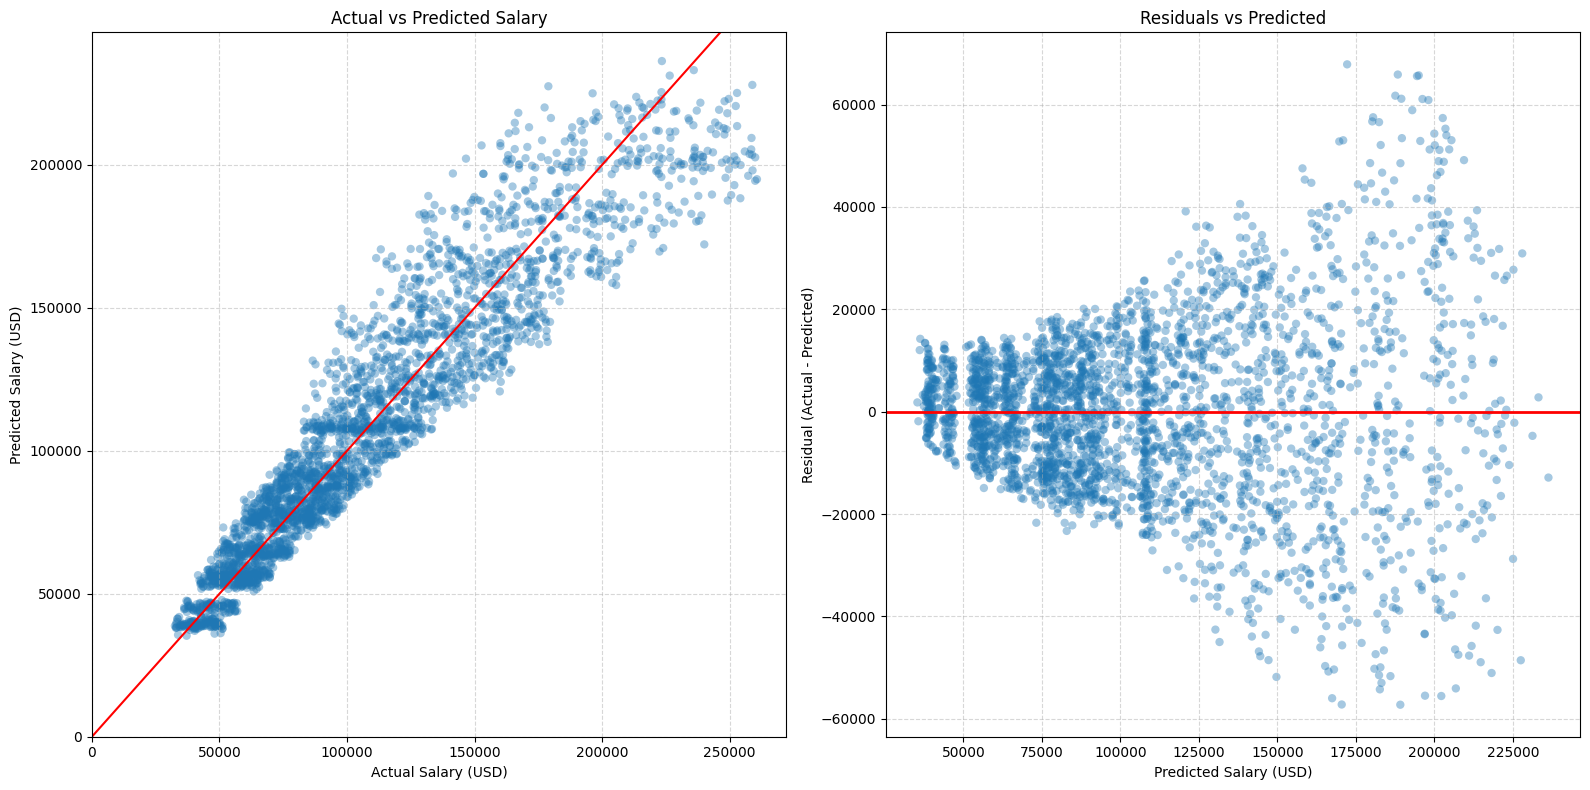

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].scatter(y_test, y_pred, alpha=0.4, edgecolor='none')
axes[0].set_xlabel('Actual Salary (USD)')
axes[0].set_ylabel('Predicted Salary (USD)')
axes[0].set_title('Actual vs Predicted Salary')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)

x = np.linspace(0, 250000, 10000)

axes[0].plot(x, x, label='y = x', color='red')

residuals = y_test - y_pred

axes[1].scatter(y_pred, residuals, alpha=0.4, edgecolor='none')
axes[1].axhline(0, color='red', linewidth=2)

axes[1].set_xlabel("Predicted Salary (USD)")
axes[1].set_ylabel("Residual (Actual - Predicted)")
axes[1].set_title("Residuals vs Predicted")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("../reports/figures/gradient_boosting_plots.pdf")
plt.show()

In [19]:
fig1 = plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolor='none')
plt.plot(x, x, color='red')
plt.xlabel('Actual Salary (USD)')
plt.ylabel('Predicted Salary (USD)')
plt.title('Actual vs Predicted Salary')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(left=0)
plt.ylim(bottom=0)
fig1.savefig("../reports/figures/gradient_boosting_actual_vs_predicted.pdf", dpi=300)
plt.close(fig1)

fig2 = plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.4, edgecolor='none')
plt.axhline(0, color='red', linewidth=2)
plt.xlabel("Predicted Salary (USD)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.grid(True, linestyle='--', alpha=0.5)
fig2.savefig("../reports/figures/gradient_boosting_residuals_plot.pdf", dpi=300)
plt.close(fig2)

# Feature Importance

group
years_experience          0.578012
company_location          0.249451
experience_level          0.112010
company_size              0.045511
required_skills           0.003271
employee_residence        0.002452
job_description_length    0.002325
job_title                 0.002125
industry                  0.001859
benefits_score            0.001821
education_required        0.000545
employment_type           0.000324
remote_ratio              0.000295
Name: importance, dtype: float64


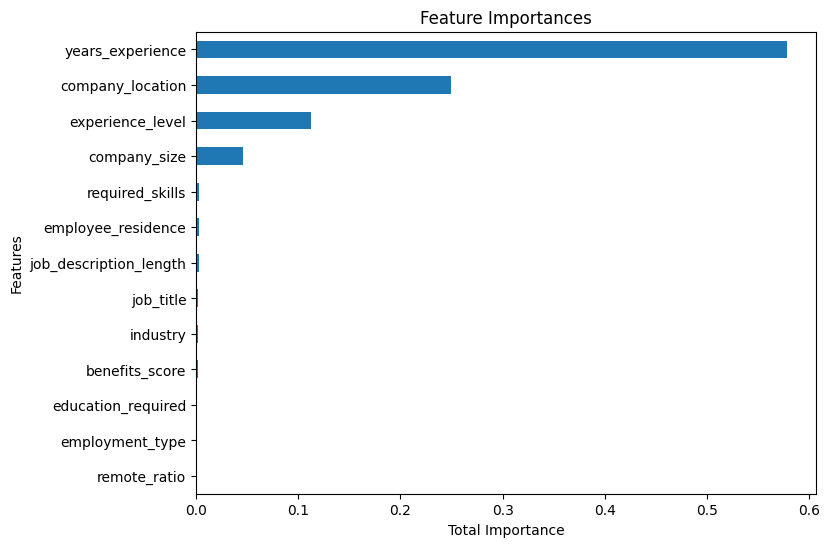

In [20]:
preprocess = best_model.named_steps["preprocess"]
gbr = best_model.named_steps["model"]

cat_features = preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols)
num_features = numeric_cols
skill_features = preprocess.named_transformers_["skills"].get_feature_names_out(text_col)

all_features = list(cat_features) + list(num_features) + list(skill_features)

feat_df = pd.DataFrame({
    "feature": all_features,
    "importance": gbr.feature_importances_
})

group_map = {}

for f in feat_df["feature"]:
    if f in numeric_cols:
        group_map[f] = f
        continue
    
    for col in categorical_cols:
        if f.startswith(col + "_"):
            group_map[f] = col
            break
    
    if f in skill_features:
        group_map[f] = "required_skills"

feat_df["group"] = feat_df["feature"].map(group_map)

grouped = (
    feat_df.groupby("group")["importance"]
    .sum()
    .sort_values(ascending=False)
)

print(grouped)

plt.figure(figsize=(8, 6))
grouped.plot(kind="barh")
plt.title("Feature Importances")
plt.xlabel("Total Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.savefig("../reports/figures/gradient_boosting_feature_importances.pdf", dpi=300)
plt.show()